In [2]:
from tslearn.clustering import TimeSeriesKMeans
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib.request import urlopen
import json

In [7]:
df = pd.read_csv('Data_Files/price_by_state_cleaned.csv')
# print(df)

split_date = '2020-01-31'  # Choose the date where to split the data
train = df[df['Unnamed: 0'] < split_date]
train = train.drop(columns=['Unnamed: 0'])
test = df[df['Unnamed: 0'] >= split_date]
test = test.drop(columns=['Unnamed: 0'])

print(train)
train = train.values.T
print(train.shape)

        California          Texas        Florida       New York  \
0    186429.815199  110538.064827  105825.018501  149355.915577   
1    187056.461453  110598.134067  106054.245342  149887.769350   
2    187902.587345  110627.268589  106332.113966  150399.764377   
3    189739.274366  110771.865807  106896.949408  151500.926494   
4    191874.146347  110865.509233  107506.063565  152640.235655   
..             ...            ...            ...            ...   
235  530193.868585  209343.329547  239240.492257  337245.003448   
236  532764.367684  209999.544387  239942.596339  337881.137431   
237  535794.434245  210878.012737  240873.009505  338598.409573   
238  539093.566334  211918.153088  242145.599112  340030.909293   
239  542512.733424  213050.724665  243713.960439  341852.920626   

      Pennsylvania       Illinois           Ohio        Georgia  \
0     96116.779767  125204.519107  101913.641903  121920.615008   
1     96322.366280  125304.858881  101975.920383  122197.4756

In [4]:
km = TimeSeriesKMeans(n_clusters=6, max_iter=1000, random_state=0)
pred = km.fit_predict(train)
print(pred)

[2 3 3 5 3 3 1 3 3 1 4 0 5 0 4 3 1 5 1 3 5 3 3 1 3 1 5 1 0 0 1 0 1 1 1 3 1
 3 1 2 0 3 0 3 0 3 3 5 2 0 0]


In [5]:
state_names = df.columns.tolist()[1:]

plot_df = pd.DataFrame({
    "State": state_names,
    "Number": pred
})

cluster = {}

for i in range(6):
    state_with_ = plot_df[plot_df["Number"] == i]["State"]
    cluster[i] = state_with_.values.tolist()
print(cluster)

{0: ['Virginia', 'Arizona', 'Connecticut', 'Utah', 'Nevada', 'New Hampshire', 'Rhode Island', 'Delaware', 'Vermont', 'Wyoming'], 1: ['Ohio', 'Michigan', 'Indiana', 'Missouri', 'Alabama', 'Kentucky', 'Oklahoma', 'Iowa', 'Arkansas', 'Mississippi', 'Kansas', 'Nebraska', 'West Virginia'], 2: ['California', 'Hawaii', 'District of Columbia'], 3: ['Texas', 'Florida', 'Pennsylvania', 'Illinois', 'Georgia', 'North Carolina', 'Tennessee', 'Wisconsin', 'Minnesota', 'South Carolina', 'Louisiana', 'New Mexico', 'Idaho', 'Maine', 'Montana', 'South Dakota', 'North Dakota'], 4: ['New Jersey', 'Massachusetts'], 5: ['New York', 'Washington', 'Maryland', 'Colorado', 'Oregon', 'Alaska']}


In [37]:
fips = pd.read_csv('Data_Files/fips.csv')

# Convert group_data to DataFrame
grouped_states = []
for group, states in cluster.items():
    for state in states:
        grouped_states.append({'Group': group, 'State': state.lower()})

grouped_df = pd.DataFrame(grouped_states)

# Merge grouped states with their codes
fips['STATE'] = fips['STATE'].str.lower()
fips = fips.rename(columns={'STATE': 'State'})
merged_df = pd.merge(grouped_df, fips, on='State', how='left')
merged_df['CODE'] = merged_df['CODE'].astype(str).str.zfill(2)
merged_df = merged_df.rename(columns={'CODE': 'STATEFP'})

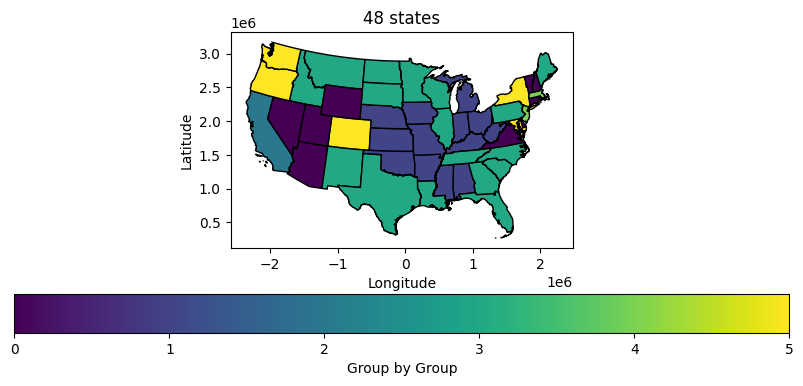

In [36]:
gdf = gpd.read_file("Data_Files/county_data.gpkg")
gdf = pd.merge(gdf, merged_df, on='STATEFP', how='left')

# new dataframe that dissolves all counties within each state and drop regions with certain codes
new_counties = gdf.dissolve(by="STATEFP", aggfunc="first")
new_counties = new_counties.drop(["02", "15", "60", "66", "69", "72", "78"])
new_counties.to_crs(5071, inplace=True)
fig, ax = plt.subplots(1, figsize=(10, 4))
base = new_counties.plot(column='Group', legend=True, legend_kwds={'label': "Group by Group",
                                      'orientation': "horizontal"}, edgecolor="black", ax=ax, linewidth=1)
ax.set_title("48 states")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()